## Convolutional Neural Networks
Train a CNN to classify images from the CIFAR-10 database.

###### Test for [CUDA](http://pytorch.org/docs/stable/cuda.html)

In [1]:
#Import Libraries
import torch
import numpy as np

#Check if CUDA is avaliable
train_on_gpu=torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is Not avaliable. Taining on CPU')
else:
    print('CUDA is avaliable . Training on GPU')

CUDA is not available.  Training on CPU ...


###### Load the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

In [2]:
#Import Libraries
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

#Define number of subprocess to use for data loading
num_workers=0
#Define samples per batch to load
batch_size=20
#Define percentage of training set to use as validation
valid_size = 0.2

#Convert data to Normalized torch.FloatTensor
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                             ])

#Download training data
trainset=datasets.CIFAR10('data',download=True,train=True,transform=transform)
#Download test data
testset=datasets.CIFAR10('data',download=True,train=False,transform=transform)

#obtain training indices that will be used for validation
num_train=len(trainset)
indices=list(range(num_train))
np.random.shuffle(indices)
split=int(np.floor(valid_size*num_train))
train_idx,valid_idx=indices[split:],indices[:split]

#Define samplers for obtaining training batches
train_sampler=SubsetRandomSampler(train_idx)
# Define samplers for obtaining validation batches
valid_sampler=SubsetRandomSampler(valid_idx)

#Load training data(combine dataset and sampler)
trainloader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,sampler=train_sampler,num_workers=num_workers)
#Load valid data(combine dataset and sampler)
validloader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,sampler=valid_sampler,num_workers=num_workers)
#Load test data(combine dataset and sampler)
testloader=torch.utils.data.DataLoader(testset,batch_size=batch_size,num_workers=num_workers)

#Define image classes
classes=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

0it [00:00, ?it/s]

100%|█████████▉| 170483712/170498071 [10:43<00:00, 558071.29it/s] 

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


###### Visualize a Batch of Training Data

In [3]:
#Import Libraries
import matplotlib.pyplot as plt
%matplotlib inline

#Create helper function to un-normalize & display images
def imshow(img):
    #Un-normalize
    img=img/2+0.5
    #Convert from tensor image
    plt.imshow(np.transpose(img,(1,2,0)))

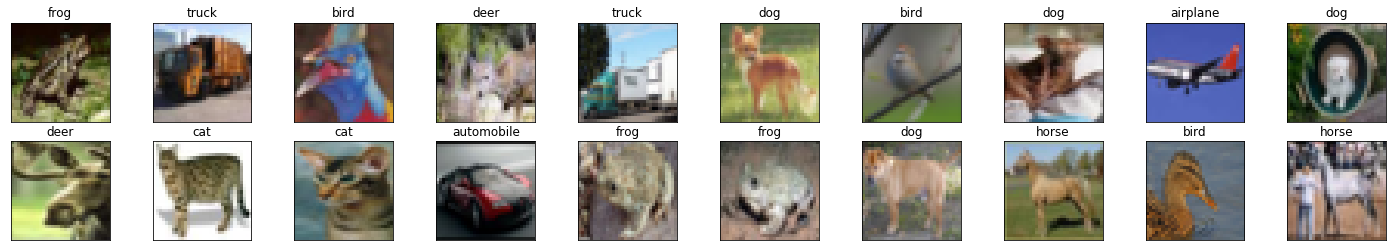

In [4]:
#Define one batch of training images
dataiter=iter(trainloader)
images,labels=dataiter.next()

#Convert images to num py to display
images=images.numpy()

#Display images in the batch with its label
fig=plt.figure(figsize=(25,4))
#Display 20 images
for idx in np.arange(20):
    ax=fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

###### View an Image in More Detail

170500096it [11:00, 558071.29it/s]                               

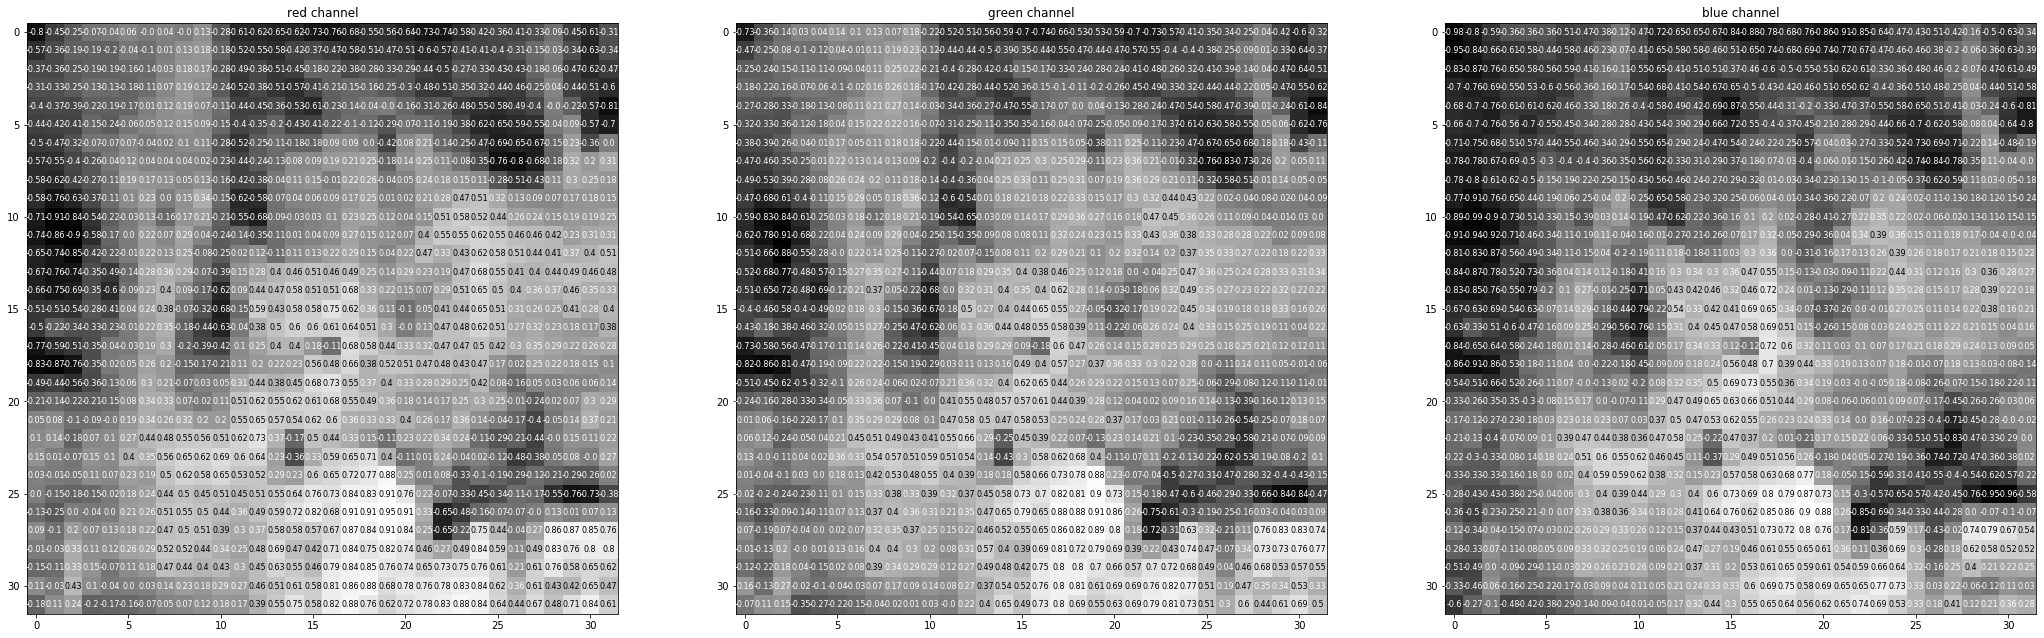

In [5]:
rgb_image=np.squeeze(images[3])
channels=['red channel','green channel','blue channel']
fig=plt.figure(figsize=(36, 36)) 
for idx in np.arange(rgb_image.shape[0]):
    ax=fig.add_subplot(1,3,idx+1)
    image=rgb_image[idx]
    ax.imshow(image,cmap='gray')
    ax.set_title(channels[idx])
    width,height=image.shape
    thresh=image.max()/2.5
    for x in range(width):
        for y in range(height):
            val=round(image[x][y],2) if image[x][y] !=0 else 0
            ax.annotate(str(val),xy=(y,x),
            horizontalalignment='center',
            verticalalignment='center',size=8,
            color='white' if image[x][y]<thresh else 'black')

###### Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)
We'll define a CNN architecture. Instead of an MLP, which used linear, fully-connected layers.
We'll use the following:
* [Convolutional layers](https://pytorch.org/docs/stable/nn.html#conv2d), which can be thought of as stack of filtered images.
* [Maxpooling layers](https://pytorch.org/docs/stable/nn.html#maxpool2d), which reduce the x-y size of an input, keeping only the most _active_ pixels from the previous layer.
* The usual Linear + Dropout layers to avoid overfitting and produce a 10-dim output.

###### TODO: Define a model with multiple convolutional layers, and define the feedforward metwork behavior.

The more convolutional layers you include, the more complex patterns in color and shape a model can detect. It's suggested that your final model include 2 or 3 convolutional layers as well as linear layers + dropout in between to avoid overfitting.

###### Output volume for a convolutional layer

We can compute the spatial size of the output volume as a function of:
> 1.The input volume size (W).
2.The kernel/filter size (F). 
3.The stride with which they are applied (S).
4.The amount of zero padding used (P) on the border. 

The correct formula for calculating how many neurons define the output_W is given by `(W−F+2P)/S+1`.

For example for a 7x7 input and a 3x3 filter with stride 1 and pad 0 we would get a 5x5 output. With stride 2 we would get a 3x3 output.

In [6]:
#Import Libraries
import torch.nn as nn
import torch.nn.functional as F

#Define CNN architecture
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        #CONV layer(sees 32x32x3 image tensor)
        self.conv1=nn.Conv2d(3,16,3,padding=1)
        #CONV layer(sees 16x16x16 image tensor)
        self.conv2=nn.Conv2d(16,32,3,padding=1)
        #CONV layer(sess 8x8x32 image tensor)
        self.conv3=nn.Conv2d(32,64,3,padding=1)
        #Max pooling layer
        self.pool=nn.MaxPool2d(2,2)
        #Linear layer(64*4*4->500)
        self.fc1=nn.Linear(64*4*4,500)
        #Linear layer(500->10)
        self.fc2=nn.Linear(500,10)
        #Droop out layer(p=0.25)
        self.dropout=nn.Dropout(0.25)
        
    #Define forward function
    def forward(self,x):
        #Add CONV layers & max pooling layers
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=self.pool(F.relu(self.conv3(x)))
        #Flatten input image
        x=x.view(-1,64*4*4)
        #Add droopout layer
        x=self.dropout(x)
        #Add first hidden layer with activation function(relu)
        x=F.relu(self.fc1(x))
        #Add droopout layer
        x=self.dropout(x)
        #Add second hidden layer with activation function(relu)
        x=self.fc2(x)
        return x
    
#Create CNN Network
model=Network()
print(model)

#Move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


###### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

###### TODO: Define the loss and optimizer and see how these choices change the loss over time.

In [7]:
#Import Librarie
import torch.optim as optim

#Define loss function(categorical Croos-Entropy)
criterion=nn.CrossEntropyLoss()

#Define Optimizer
optimizer=optim.SGD(model.parameters(),lr=0.01)

###### Train the Network

In [8]:
#Define number of epochs to train the model
n_epochs=30
#track change in validation loss
valid_loss_min=np.Inf 

for epoch in range(1, n_epochs+1):
    #keep track of training and validation loss
    train_loss=0.0
    valid_loss=0.0
    
    #Train the model 
    model.train()
    for data,target in trainloader:
        #move tensors to GPU if CUDA is available
        if train_on_gpu:
            data,target=data.cuda(),target.cuda()
        #1.clear the gradients of all optimized variables
        optimizer.zero_grad()
        #2.forward pass: compute predicted outputs by passing inputs to the model
        output=model(data)
        #3.calculate the batch loss
        loss=criterion(output, target)
        #4.backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        #5.perform a single optimization step (parameter update)
        optimizer.step()
        #6.update training loss
        train_loss+=loss.item()*data.size(0)
         
    #validate the model
    model.eval()
    for data, target in validloader:
        #move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target=data.cuda(), target.cuda()
        #1.forward pass: compute predicted outputs by passing inputs to the model
        output=model(data)
        #2.calculate the batch loss
        loss=criterion(output, target)
        #3.update average validation loss 
        valid_loss+=loss.item()*data.size(0)
    
    #calculate average losses
    train_loss=train_loss/len(trainloader.sampler)
    valid_loss=valid_loss/len(validloader.sampler)
        
    #print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    #save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(),'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.109981 	Validation Loss: 1.819298
Validation loss decreased (inf --> 1.819298).  Saving model ...
Epoch: 2 	Training Loss: 1.665093 	Validation Loss: 1.510651
Validation loss decreased (1.819298 --> 1.510651).  Saving model ...
Epoch: 3 	Training Loss: 1.487293 	Validation Loss: 1.383373
Validation loss decreased (1.510651 --> 1.383373).  Saving model ...
Epoch: 4 	Training Loss: 1.374530 	Validation Loss: 1.333518
Validation loss decreased (1.383373 --> 1.333518).  Saving model ...
Epoch: 5 	Training Loss: 1.278435 	Validation Loss: 1.222941
Validation loss decreased (1.333518 --> 1.222941).  Saving model ...
Epoch: 6 	Training Loss: 1.196933 	Validation Loss: 1.106364
Validation loss decreased (1.222941 --> 1.106364).  Saving model ...
Epoch: 7 	Training Loss: 1.128540 	Validation Loss: 1.072447
Validation loss decreased (1.106364 --> 1.072447).  Saving model ...
Epoch: 8 	Training Loss: 1.064471 	Validation Loss: 1.009052
Validation loss decreased (1.07244

###### Load the Model with the Lowest Validation Loss

In [9]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

###### Test the Trained Network

In [10]:
#track test loss
test_loss=0.0
class_correct=list(0. for i in range(10))
class_total=list(0. for i in range(10))

model.eval()
#iterate over test data
for data, target in testloader:
    #move tensors to GPU if CUDA is available
    if train_on_gpu:
        data,target=data.cuda(),target.cuda()
    #1.forward pass: compute predicted outputs by passing inputs to the model
    output=model(data)
    #2.calculate the batch loss
    loss=criterion(output,target)
    #3.update test loss 
    test_loss+=loss.item()*data.size(0)
    #4.convert output probabilities to predicted class
    _, pred=torch.max(output,1)    
    #5.compare predictions to true label
    correct_tensor=pred.eq(target.data.view_as(pred))
    correct=np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    #6.calculate test accuracy for each object class
    for i in range(batch_size):
        label=target.data[i]
        class_correct[label]+=correct[i].item()
        class_total[label]+=1

# average test loss
test_loss=test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100*class_correct[i]/class_total[i],
            np.sum(class_correct[i]),np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100.*np.sum(class_correct)/np.sum(class_total),
    np.sum(class_correct),np.sum(class_total)))

Test Loss: 0.745618

Test Accuracy of airplane: 83% (831/1000)
Test Accuracy of automobile: 86% (861/1000)
Test Accuracy of  bird: 66% (660/1000)
Test Accuracy of   cat: 59% (597/1000)
Test Accuracy of  deer: 67% (677/1000)
Test Accuracy of   dog: 63% (639/1000)
Test Accuracy of  frog: 82% (827/1000)
Test Accuracy of horse: 76% (767/1000)
Test Accuracy of  ship: 87% (877/1000)
Test Accuracy of truck: 78% (784/1000)

Test Accuracy (Overall): 75% (7520/10000)


###### Question: What are your model's weaknesses and how might they be improved?

**Answer**: This model seems to do best on vehicles rather than animals. For example, it does best on the automobile class and worst on the cat class. I suspect it's because animals vary in color and size and so it would improve this model if I could increase the number of animal images in the first place or perhaps if I added another convolutional layer to detect finer patterns in these images. I could also experiment with a smaller learning rate so that the model takes small steps in the right direction as it is training.

###### Visualize Sample Test Results

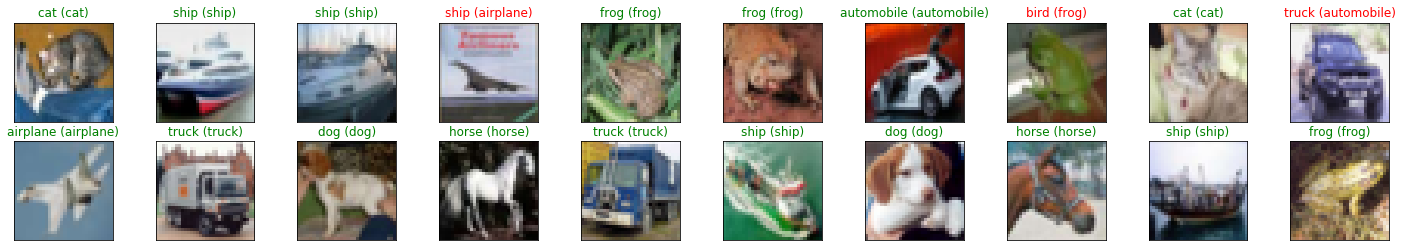

In [11]:
#obtain one batch of test images
dataiter=iter(testloader)
images,labels=dataiter.next()
images.numpy()

#move model inputs to cuda, if GPU available
if train_on_gpu:
    images=images.cuda()

#get sample outputs
output=model(images)
# convert output probabilities to predicted class
_, preds_tensor=torch.max(output,1)
preds=np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

#plot the images in the batch, along with predicted and true labels
fig=plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax=fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]],classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))